In [24]:
SEED = 36

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re,string,unicodedata
from collections import Counter

import matplotlib.cm as cm 
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import keras
from keras.models import load_model, model_from_json, Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Flatten, LSTM, Bidirectional, Dropout, concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import Input, Model

from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import seaborn as sns

from wordsegment import load, segment

import contractions 

import tensorflow as tf
import os
import random as rn

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

## Inicializações

#### NLTK

In [4]:
nltk.download()
nltk.download('stopwords')

lista_stopwords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
lista_stopwords.update(punctuation)
nltk.download('wordnet')

#word segmentation
load()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
ARQUIVO_GLOVE_100 = 'glove.6B.100d.txt'
ARQUIVO_GLOVE_100_TWITTER = 'glove.twitter.27B.100d.txt'
ARQUIVO_GLOVE_200_TWITTER = 'glove.twitter.27B.200d.txt'

## Funções

#### Utilitários

In [6]:
# Carrega o arquivo de Embeddings
def read_embedding(file_name, dim_size):
    with open(file_name,'r', encoding="utf8") as f:
        word_vocab = {} 
        word2vector = []
        pos = 0
        for line in f:
            line_ = line.strip() 
            words_vec = line_.split()
            
            if (len(words_vec) == dim_size + 1):
                word_vocab[words_vec[0]] = pos
                word2vector.append(np.array(words_vec[1:],dtype=float)) 
                pos+=1
            
    print("Total Words in DataSet:",len(word_vocab))
    word2vector = np.stack(word2vector)
    return word_vocab,word2vector

In [7]:
def load_dict_smileyfaces():
    
    return {
        ":‑)":"smileyface", ":-]":"smileyface", ":-3":"smileyface", ":->":"smileyface", "8-)":"smileyface",
        ":-}":"smileyface", ":)":"smileyface", ":]":"smileyface", ":3":"smileyface", ":>":"smileyface", 
        "8)":"smileyface",":}":"smileyface", ":o)":"smileyface", ":c)":"smileyface", ":^)":"smileyface", 
        "=]":"smileyface", "=)":"smileyface", ":-))":"smileyface", ":‑D":"smileyface", "8‑D":"smileyface",
        "x‑D":"smileyface", "X‑D":"smileyface", ":D":"smileyface", "8D":"smileyface", "xD":"smileyface",
        "XD":"smileyface", ":‑(":"sadface", ":‑c":"sadface", ":‑<":"sadface", ":‑[":"sadface", ":(":"sadface",
        ":c":"sadface", ":<":"sadface", ":[":"sadface", ":-||":"sadface", ">:[":"sadface", ":{":"sadface",
        ":@":"sadface", ">:(":"sadface", ":'‑(":"sadface", ":'(":"sadface", ":‑P":"playful", "X‑P":"playful",
        "x‑p":"playful", ":‑p":"playful", ":‑Þ":"playful", ":‑þ":"playful", ":‑b":"playful", ":P":"playful",
        "XP":"playful", "xp":"playful", ":p":"playful", ":Þ":"playful", ":þ":"playful",":b":"playful", "<3":"love"
        }

In [8]:
def get_sinonimo(str):
    dict_sinonimos = {'covid': ['coronavirus'], 'covid2019': ['coronavirus'],  'covid-19': ['coronavirus'], 'chloroquine':['medicine'],
                      'hydroxychloroquine': ['medicine'],  'oversupply':['over', 'supply'], 'unavailability':['unavailable'], 'downscaling' : ['scale', 'down'],
                      'immunocompromised' : ['immunology', 'compromised'], 'nationalizing': ['make', 'national'], 'deflationary': ['deflation'],
                      'feedstock': ['raw', 'material'], 'extortionist': ['extortion'], 'formulary': ['form'], 'disinfection': ['disinfect'],
                      'deflationary': ['deflation'], 'exorbitantly': ['exorbitant'], 'overpricing': ['excessive', 'price'], 'prepayment': ['pre', 'payment'],
                      'supressed': ['suppressed'], 'sanitization' : ['sanitation'], 'sanitising': ['sanitation'], 'sanitise': ['sanitize'],
                      'isopropyl': ['alcohol'], 'quarantining': ['quarantine'], 'nonessential': ['not', 'essential'], 'exportation': ['export'],
                      'pivoted': ['pivot'], 'humoured': ['humorous'], 'expediting': ['speeding', 'up'], 'overproduction': ['abundance'], 'oilpatch': ['oil', 'patch'],
                      'oilseeds': ['oil', 'seeds'], 'virologist': ['virology', 'scientist'], 'sterilizing': ['sterilize'], 'mainstreamed': ['integrated'],
                      'medcine': ['medicine'], 'counterfeiters': ['counterfeits'], 'schmeling': ['gossiping'], 'denatured': ['denature'],
                      'retrofitting': ['renovation'], 'bogglingly': ['frighteningly'], 'upended': ['overthrown'], 'immunosuppressed':['suppressed', 'immunology'],
                      'immunosuppressants': ['suppressed', 'immunology'], 'backlogged':['accumulated'], 'quarenteen': ['quarentena']
                     }
    sinonimo = []
    
    if str in dict_sinonimos:
        sinonimo = dict_sinonimos[str]
    return sinonimo

### Tratamento Labels

In [9]:
#Labels. Pemite agrupar negativos e positivos
def get_labels_dict(agrupar_labels):
    if not agrupar_labels:
        return {'Extremely Negative': -2 , 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
    else:
        return {'Negative': -1 ,'Neutral': 0, 'Positive': 1}    
    
    
# Converter labels da representação textual para one hot encode
def convert_labels_to_hot_encode(labels, labels_dict, agrupar_labels):
    if agrupar_labels:
        labels_conv =[labels_dict[label.split()[-1]] for label in labels]
    else:
        labels_conv =[labels_dict[label] for label in labels]
    df_dummified = pd.get_dummies(labels_conv)
    
    columns = df_dummified.columns
    print(columns)
    
    return df_dummified.to_numpy()

---

## Pré-Processamento

#### Limpeza dos Dados

In [10]:
def limpa_texto(texto, use_hashtag_embedding):
    # link
    texto = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '<url>', texto) #retirei url
    # numero string com números não estamos retirando inicialmente (COVID-19)
    texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', '<number>', texto) #retirei number
    
    #texto = re.sub(r'\b([A-Z]+)\b', '<allcaps> \g<1>', texto)
    
    smileyfaces = load_dict_smileyfaces()
    for s in smileyfaces:
        if s in texto:
            texto = texto.replace(s,smileyfaces[s])
    
    if use_hashtag_embedding:
        texto = re.sub(r'#([\w]+)', '<hashtag> \g<1>', texto)
    else:
        texto = re.sub(r'#', '', texto)
    
    texto = re.sub(r"[\.\,\!\?\:\;\-\=\(\)]", '', texto)
    
    texto = re.sub(r'\s+', ' ', texto)
    return texto

### Separação de Tokens

In [11]:
# separa tokens por representação vetorial
def split_tokens_word_vec(texto, vocab, use_twitter_tokenizer, min_length_word):
    lemmatizer = WordNetLemmatizer()
    
    texto = contractions.fix(texto) 
        
    lista_tokens_inicial = []
    if use_twitter_tokenizer:
        t_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lista_tokens_inicial = t_tokenizer.tokenize(texto)
    else:
        lista_tokens_inicial = word_tokenize(texto)
    
    tokens_encontrados = []
    tokens_nao_encontrados = []
    
    for token in lista_tokens_inicial:
        add_token = True
        
        #if token in lista_stopwords:
            #add_token = False
        
        if len(token) < min_length_word:
            add_token = False
        
        if add_token:
            if token.lower() in vocab:
                tokens_encontrados.append(token.lower())
            else:
                sinonimo = get_sinonimo(token.lower())
                if len(sinonimo) > 0:
                    tokens_encontrados.extend(sinonimo)
                else:
                    tokens_salvos = trata_token_nao_encontrado(token, vocab)
                    if len(tokens_salvos) > 0:
                        tokens_encontrados.extend(tokens_salvos)
                    else:
                        #tokens_encontrados.append('<unknown>')
                        tokens_nao_encontrados.append(token)
    return tokens_encontrados, tokens_nao_encontrados
        

In [12]:
def trata_token_nao_encontrado(token, vocab):
    lemmatizer = WordNetLemmatizer()
    tokens_salvos = []
    
    token_lemmatizado = lemmatizer.lemmatize(token)
    
    if token != token_lemmatizado:
        if token_lemmatizado in vocab:
            return [token_lemmatizado]
        
    tokens_word_segmentation = segment(token)
    
    for subtoken in tokens_word_segmentation:
        if subtoken in vocab:
            tokens_salvos.append(subtoken)
        else:
            subtoken_lemmatizado = lemmatizer.lemmatize(subtoken)
            if (subtoken_lemmatizado in vocab):
                tokens_salvos.append(subtoken_lemmatizado)
            else:
                sinonimo = get_sinonimo(subtoken)
                if len(sinonimo) > 0:
                    tokens_salvos.extend(sinonimo)          
                elif subtoken[-1] == 's':
                    if subtoken[:-1] in vocab:
                        tokens_salvos.append(subtoken[:-1])
                
                
    return tokens_salvos
        
        

In [13]:
def carrega_tokens_word_vec(lista_tweet, vocab, use_twitter_tokenizer,  min_length_word, use_hashtag_embedding):
    feature_tokens = []
    feature_tokens_verificar =[]
    for tweet in lista_tweet:
        texto_limpo = limpa_texto(tweet, use_hashtag_embedding)
        tokens_add, tokens_verify = split_tokens_word_vec(texto_limpo, 
                                                          vocab,
                                                          use_twitter_tokenizer=use_twitter_tokenizer, 
                                                          min_length_word=min_length_word)
        feature_tokens.append(np.asarray(tokens_add))
        feature_tokens_verificar.append(tokens_verify)
    
    
    feature_tokens = np.asarray(feature_tokens)
    feature_tokens_verificar = np.asarray(feature_tokens_verificar)
    
    return feature_tokens, feature_tokens_verificar

In [14]:
def pre_processamento_word_vec(dados, 
                               agrupar_labels=False, 
                               glove_twitter=True, 
                               min_length_word=0, 
                               convert_labels_hot_encode=True, 
                               use_twitter_tokenizer=True,
                               use_hashtag_embedding=False):
    arquivo_glove = ARQUIVO_GLOVE_200_TWITTER
    if not glove_twitter :
        arquivo_glove = ARQUIVO_GLOVE_100
    
    lista_tweet = dados.OriginalTweet
    labels_str = dados.Sentiment
    lista_sentimentos = dados.Sentiment.unique()
    
    vocab, embedding = read_embedding(arquivo_glove, 200)
    
    labels_dict = get_labels_dict(agrupar_labels)
    if convert_labels_hot_encode:
        labels = convert_labels_to_hot_encode(labels_str, labels_dict, agrupar_labels)
    else:
        if (agrupar_labels):
            labels = [labels_dict[label.split()[-1]] for label in labels_str]
        else:
            labels = [labels_dict[label] for label in labels_str]
        labels = np.asarray(labels)
    
    feature_tokens, feature_tokens_verificar = carrega_tokens_word_vec(lista_tweet, 
                                                                       vocab, 
                                                                       use_twitter_tokenizer=use_twitter_tokenizer, 
                                                                       min_length_word=min_length_word,
                                                                      use_hashtag_embedding=use_hashtag_embedding)
        
    return (vocab, embedding), (feature_tokens, feature_tokens_verificar), labels, labels_dict
    
    
    
def pre_processamento_word_vec_test(dados, 
                                    vocab,
                                    labels_dict,
                                   agrupar_labels=False, 
                                   glove_twitter=True, 
                                   min_length_word=0, 
                                   use_twitter_tokenizer=True, 
                                   use_hashtag_embedding=False):
    
    arquivo_glove = ARQUIVO_GLOVE_100_TWITTER
    if not glove_twitter :
        arquivo_glove = ARQUIVO_GLOVE_100
    
    lista_tweet = dados.OriginalTweet
    labels_str = dados.Sentiment
    
    
    labels = convert_labels_to_hot_encode(labels_str, labels_dict, agrupar_labels)
    
    feature_tokens, _ = carrega_tokens_word_vec(lista_tweet, 
                                                vocab, 
                                                use_twitter_tokenizer=use_twitter_tokenizer, 
                                                min_length_word=min_length_word,
                                                use_hashtag_embedding=use_hashtag_embedding)
        
    return feature_tokens, labels

## Modelos Criados para o Desafio

### Conversão dos token para indices embedding, preparando para entrada na RNN

In [15]:
# Converter tokens para a representação word vec
def convert_feature_tokens_to_word_vec(feature_tokens,  vocab, dimension_size=100, max_word_length=50):
    feature_word_vec = np.zeros((len(feature_tokens), max_word_length), dtype='int32')
    
    for c_feature, f_token in enumerate(feature_tokens):
        for c_token,token in enumerate(f_token):
            if(c_token < max_word_length):
                feature_word_vec[c_feature,c_token] = vocab[token]
        
    return feature_word_vec
    

### Variações de Modelos RNN - LSTM 1 camada, LSTM 2 camadas, Convolucionais, BI-LSTM, BI-LSTM 2 camadas, ...

In [16]:
def create_model_lstm_pure(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.50))
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model


def create_model_lstm_pure_bi(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.50))
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model


def create_model_lstm_dense(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

def create_model_lstm_bi_dense(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

def create_model_lstm_conv(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    # model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

def crate_model_double_lstm(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    model.add(Bidirectional(LSTM(150, return_sequences=True, recurrent_dropout=0.3)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(150, recurrent_dropout=0.3, return_sequences=True)))
    #model.add(Dense(512, activation='relu')) #60
    model.add(GlobalMaxPooling1D())
    #model.add(GlobalAveragePooling1D())
    #model.add(Dense(128, activation='relu')) 
    model.add(Dense(num_labels, activation='softmax'))
    # Adam Optimiser 
    # testar Adam(lr=0.01, decay=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.01, decay=0.001), metrics=['accuracy'])
    
    return model

def create_model_aula_rnn(weight_matrix, dim_embedding, max_words_length, num_labels=5):
    inp = Input(shape=(max_words_length,))
    x = Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False)(inp)
    x = Bidirectional(LSTM(150, return_sequences=True, recurrent_dropout=0.3))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(150, recurrent_dropout=0.3, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool,max_pool])
    x = Dense(num_labels, activation='softmax') (x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.01, decay=0.001), metrics=['accuracy'])
    
    return model
    

# Execução

### Carga dos dados, pré-processamento e conversão dos tokens para entrada na rede neural

In [17]:
max_word_length=55
use_hashtag_embedding=True


dados = pd.read_csv('Corona_NLP_train.csv', engine="python")
dados_test = pd.read_csv('Corona_NLP_test.csv', engine="python")

(vocab, embedding), (feature_tokens, _), labels, labels_dict = pre_processamento_word_vec(dados, 
                                                                                          agrupar_labels=True,
                                                                                          glove_twitter=True, 
                                                                                          convert_labels_hot_encode=True,
                                                                                          min_length_word=1,
                                                                                          use_twitter_tokenizer=True,
                                                                                          use_hashtag_embedding=use_hashtag_embedding)

X_train, X_val, y_train, y_val = train_test_split(feature_tokens, labels,  test_size=0.2, random_state=0)

X_train = convert_feature_tokens_to_word_vec(X_train, 
                                             vocab,
                                             max_word_length=max_word_length)
X_val = convert_feature_tokens_to_word_vec(X_val, 
                                           vocab, 
                                           max_word_length=max_word_length)

X_test, y_test = pre_processamento_word_vec_test(dados_test,
                                          vocab,
                                          labels_dict,
                                          agrupar_labels=True,
                                          glove_twitter=True,
                                          min_length_word=1,
                                          use_twitter_tokenizer=True,
                                          use_hashtag_embedding=use_hashtag_embedding)

X_test = convert_feature_tokens_to_word_vec(X_test, 
                                           vocab, 
                                           max_word_length=max_word_length)



Total Words in DataSet: 1193513
Int64Index([-1, 0, 1], dtype='int64')


C:\Users\gdutr\miniconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Int64Index([-1, 0, 1], dtype='int64')


---

# Melhores Modelos Identificados - Resulado Final para avaliação

#### Grava o modelo com melhor resultado na validação para execução do teste

### Duas Camadas Bi-LSTM com average e max pool, concatenadas - 89,1%

In [25]:
model_dobule_lstm_avg_max_pool = create_model_aula_rnn(embedding, 200, max_word_length, len(labels_dict))

filepath="weights_best_double_lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]

history_double_lstm = model_dobule_lstm_avg_max_pool.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=10, callbacks=callbacks_list)


Epoch 1/10
1029/1029 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7545
Epoch 00001: val_accuracy improved from -inf to 0.85119, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 273s 266ms/step - loss: 0.6008 - accuracy: 0.7545 - val_loss: 0.4129 - val_accuracy: 0.8512
Epoch 2/10
1029/1029 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8769
Epoch 00002: val_accuracy improved from 0.85119 to 0.88168, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 315s 306ms/step - loss: 0.3499 - accuracy: 0.8769 - val_loss: 0.3402 - val_accuracy: 0.8817
Epoch 3/10
1029/1029 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9140
Epoch 00003: val_accuracy improved from 0.88168 to 0.89832, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 314s 305ms/step - loss: 0.2562 - accuracy: 0.9140 - val_loss: 0.3089 - v

In [26]:
filepath="weights_best_double_lstm.hdf5"
model_dobule_lstm_avg_max_pool.load_weights(filepath)
evaluate_double_lstm_avg_max_pool = model_dobule_lstm_avg_max_pool.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_double_lstm_avg_max_pool[0],evaluate_double_lstm_avg_max_pool[1]))

119/119 [==============================] - 8s 64ms/step - loss: 0.4837 - accuracy: 0.8910
Test set
  Loss: 0.484
  Accuracy: 0.891


---

### Bi-LSTM com GlobalMaxPooling1D - 88,6%

In [16]:
model_dobule_lstm = crate_model_double_lstm(embedding, 200, max_word_length, len(labels_dict))

filepath="weights_best_double_lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]

history_double_lstm = model_dobule_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=10, callbacks=callbacks_list)


Epoch 1/10
1029/1029 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7530
Epoch 00001: val_accuracy improved from -inf to 0.85204, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 320s 311ms/step - loss: 0.6034 - accuracy: 0.7530 - val_loss: 0.4163 - val_accuracy: 0.8520
Epoch 2/10
1029/1029 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8749
Epoch 00002: val_accuracy improved from 0.85204 to 0.88593, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 345s 336ms/step - loss: 0.3551 - accuracy: 0.8749 - val_loss: 0.3308 - val_accuracy: 0.8859
Epoch 3/10
1029/1029 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9117
Epoch 00003: val_accuracy improved from 0.88593 to 0.89310, saving model to weights_best_double_lstm.hdf5
1029/1029 [==============================] - 347s 338ms/step - loss: 0.2587 - accuracy: 0.9117 - val_loss: 0.3184 - v

#### Execução do Teste - Nota final do modelo

In [17]:
filepath="weights_best_double_lstm.hdf5"
model_dobule_lstm.load_weights(filepath)
evaluate_double_lstm = model_dobule_lstm.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_double_lstm[0],evaluate_double_lstm[1]))

119/119 [==============================] - 10s 83ms/step - loss: 0.3627 - accuracy: 0.8863
Test set
  Loss: 0.363
  Accuracy: 0.886


---

### Testes com Modelos (Resultados inferiores)

In [ ]:
model_pure = create_model_lstm_pure(embedding, 100, max_word_length, len(labels_dict))
history_pure = model_pure.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=20)

In [ ]:
evaluate_pure = model_pure.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_pure[0],evaluate_pure[1]))

In [ ]:
model_pure_bi = create_model_lstm_pure_bi(embedding, 100, max_word_length, len(labels_dict))
history_pure_bi = model_pure_bi.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=20)

In [ ]:
evaluate_pure_bi = model_pure_bi.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_pure_bi[0],evaluate_pure_bi[1]))

In [ ]:
model_dense = create_model_lstm_dense(embedding, 100, max_word_length, len(labels_dict))
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=20)

In [ ]:
evaluate_dense = model_dense.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_dense[0],evaluate_dense[1]))

In [ ]:
model_bi_dense = create_model_lstm_bi_dense(embedding, 100, max_word_length, len(labels_dict))
history_bi_dense = model_bi_dense.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=20)

In [ ]:
evaluate_bi_dense = model_bi_dense.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluate_bi_dense[0],evaluate_bi_dense[1]))

In [ ]:
model_lstm_conv = create_model_lstm_conv(embedding, 100, max_word_length, len(labels_dict))
filepath="weights_best_lstm_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]
history_bi_dense = model_lstm_conv.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=20, callbacks=callbacks_list)


---

## Word Cloud

In [37]:
# Wordcloud
def monta_wordcloud(lista_topicos, texto_ou_frequencia, generate_from_text=True):
    num_topicos = len(lista_topicos)
    ncols = 2
    col = 0
    lin  = 1

    fig, ax = plt.subplots(1, ncols, figsize=(30, 20))

    for topico in lista_topicos:
        if generate_from_text:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate(texto_ou_frequencia[topico])
        else:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate_from_frequencies(texto_ou_frequencia[topico])
    
        ax[col].imshow(wordcloud) 
        ax[col].set_title(f"{topico}")
        # No axis details
        ax[col].axis("off");
        col = col + 1
        if col >= ncols:
            plt.show()
            lin = lin + 1
            col = 0
            ax_cols =  ncols
            fig, ax = plt.subplots(1, ax_cols, figsize=(30, 20))   

In [35]:
dados = pd.read_csv('Corona_NLP_test.csv', engine="python")
(_, _), (feature_tokens, feature_tokens_verificar) , labels, labels_dict = pre_processamento_word_vec(dados, 
                                                                                                      glove_twitter=True, 
                                                                                                      convert_labels_hot_encode=False,
                                                                                                      min_length_word=2)

Total Words in DataSet: 1193513


### Word Cloud por Sentimento

In [ ]:
text_sentimento = {}
for sentimento in labels_dict:
    text_sentimento[sentimento] = " ".join([token for index, f_token in enumerate(feature_tokens) if labels[index] == labels_dict[sentimento] for token in f_token ])  
monta_wordcloud(labels_dict, text_sentimento)

### Word Cloud por Trending/Sentimento

In [ ]:
_count_trends = Counter()
_count_trends.update([token for index, lista_token in enumerate(X_tokens + X_tokens_verificar) if y[index] == sentimento for token in lista_token if re.match(r'#\w+',token) ])
monta_wordcloud(lista_sentimentos, _count_trends, generate_from_text=False)


### Word Cloud palavras não Encontradas (Sem Trending)

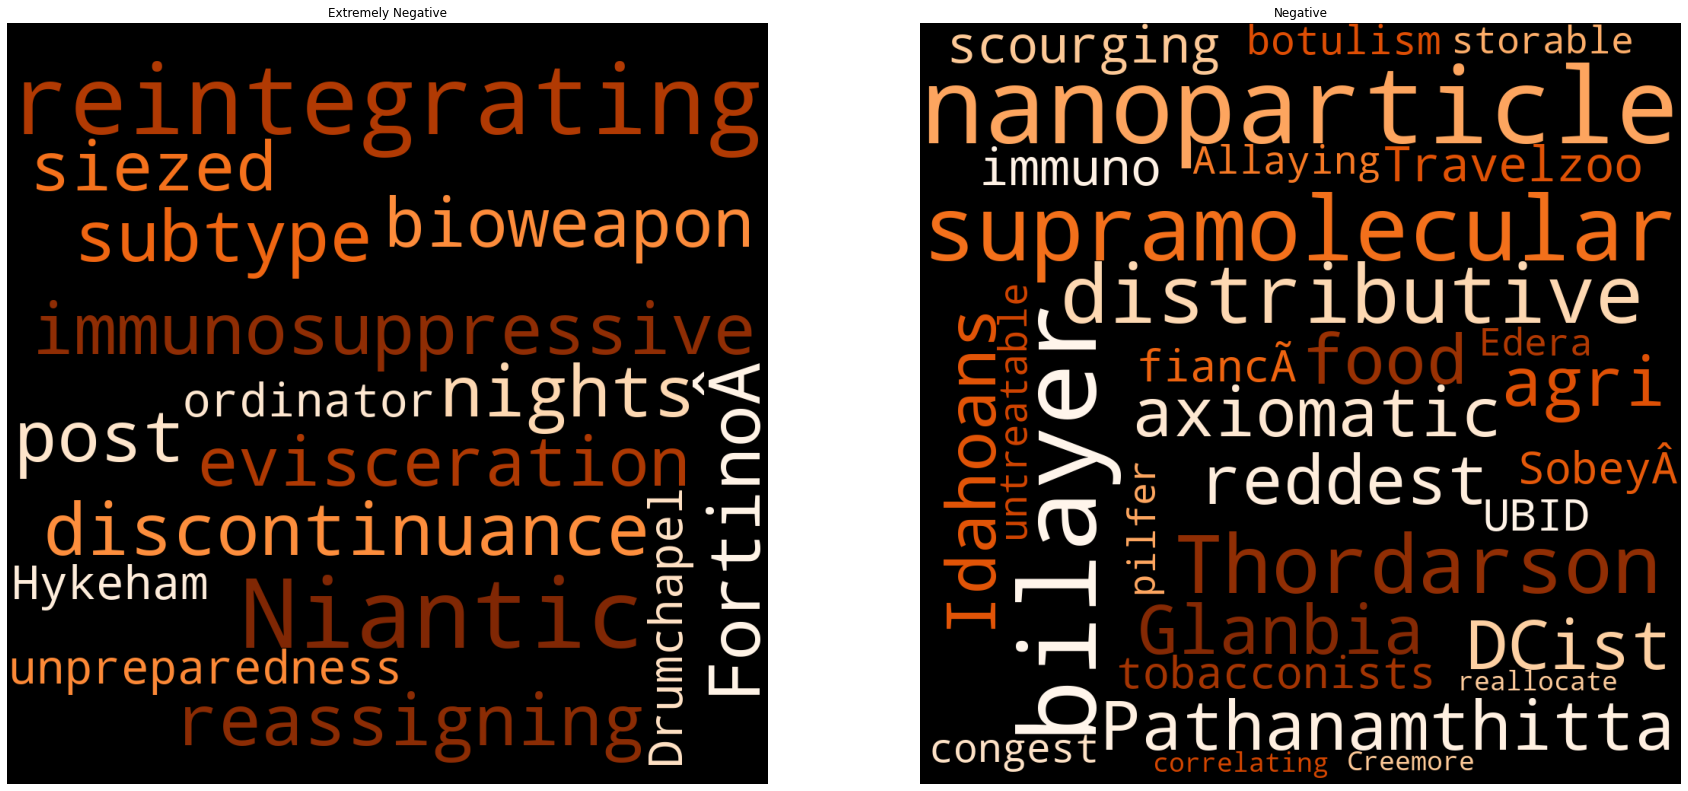

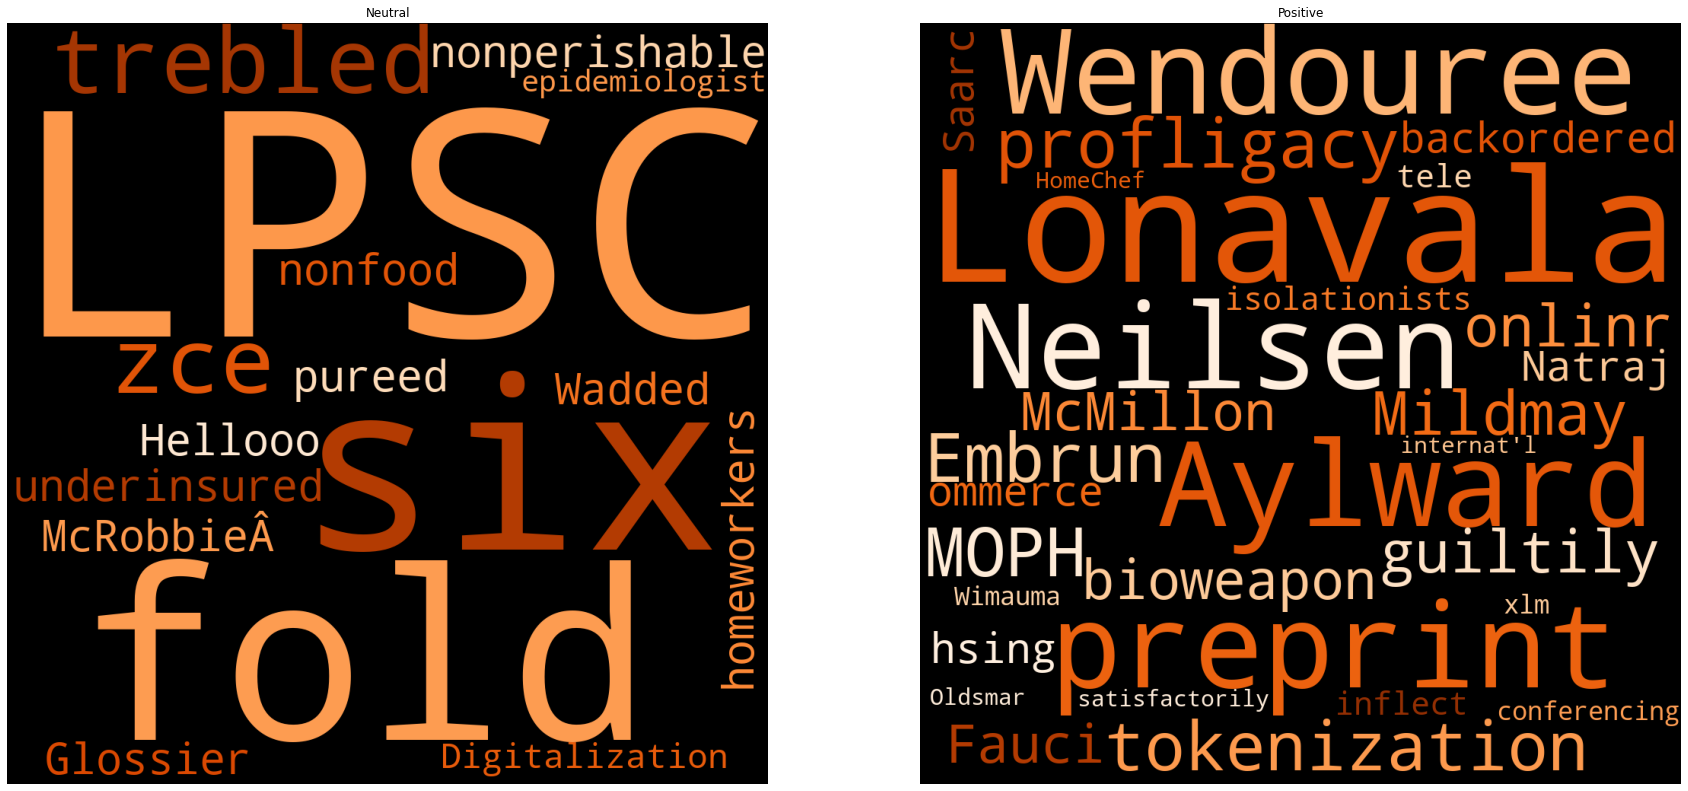

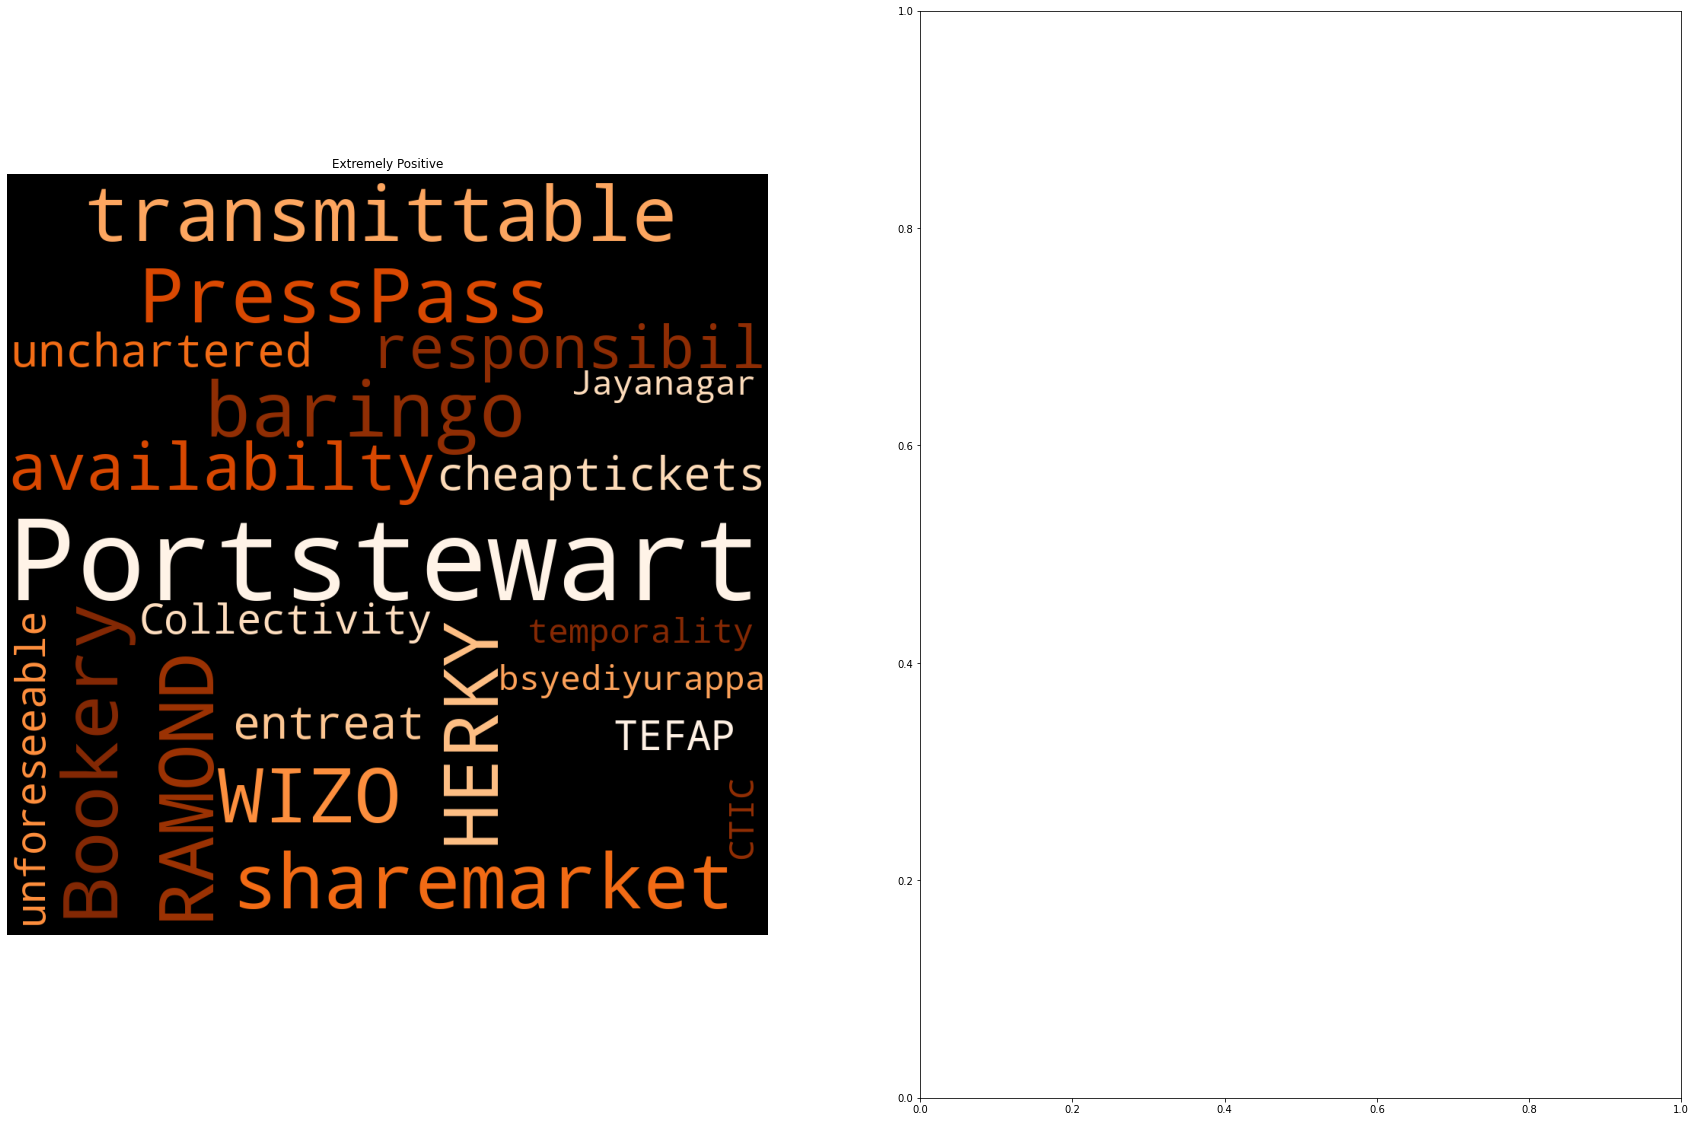

In [38]:
text_sentimento = {}
for sentimento in labels_dict:
    text_sentimento[sentimento] = " ".join([token for index, f_token in enumerate(feature_tokens_verificar) if labels[index] == labels_dict[sentimento] for token in f_token ])  
monta_wordcloud(labels_dict, text_sentimento)

